# ML Classifers (4 or more)
### Project Title - An AI Perspective on the Cryptocurrency Market: Predicting Pump-and-Dump Schemes
### Team Members - Cyrena Burke and Daniel Olaes

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Load the dataset
df = pd.read_csv("processed_crypto_data_with_labels.csv")

# Feature engineering
df['datetime'] = pd.to_datetime(df['Unix Timestamp'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['is_day'] = df['hour'].apply(lambda h: 1 if 7 <= h < 19 else 0)

X = df[['Volume Currency', 'Volume USD', 'Price Range', 'is_day']]
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)


## Model Training

Random Forest is trained on all features, aiming for full coverage of the data.

Gradient Boosting is trained on a reduced set of top features, focusing on efficiency and potentially avoiding overfitting.

Both models are evaluated using their predictions and probability scores, and are part of a comparative analysis for pump-and-dump detection.

### Training Random Forest (Full Feature Set)
Initializes a Random Forest classifier with 100 trees.

Trains the model on the full training set (X_train, y_train).

Makes predictions on the test set (X_test).

Retrieves the predicted probability of each test sample being class 1 (manipulation).

### Reducing Features for Gradient Boosting
Uses SelectKBest with ANOVA F-value scoring to choose the top 3 features most relevant to the target variable.

Applies this feature selection to both training and testing sets.

### Training Gradient Boosting (Reduced Features)
Initializes a Gradient Boosting classifier with 100 boosting stages.

Trains it on the reduced training data.

Predicts labels for the reduced test set.

Retrieves the predicted probability of manipulation.

In [3]:

# Train Random Forest on full features
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Reduced features for Gradient Boosting
selector = SelectKBest(score_func=f_classif, k=3)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

# Train Gradient Boosting
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X_train_reduced, y_train)
y_pred_gb = model_gb.predict(X_test_reduced)
proba_gb = model_gb.predict_proba(X_test_reduced)[:, 1]


## Model Evaluation
Computes four key classification metrics:

    Accuracy – how often the model predicts correctly.

    Precision – how many of the predicted positives are true positives.

    Recall – how many actual positives the model correctly identified.

    F1 Score – the harmonic mean of precision and recall.

Evaluates performance of:

    Random Forest using y_pred_rf

    Gradient Boosting using y_pred_gb

Both are compared against the same true labels from the test set y_test

In [4]:

# Evaluate models
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0)
    }

metrics_rf = evaluate_model(y_test, y_pred_rf)
metrics_gb = evaluate_model(y_test, y_pred_gb)

metrics_df = pd.DataFrame([metrics_rf, metrics_gb], index=["Random Forest", "Gradient Boosting"])
metrics_df


,Accuracy,Precision,Recall,F1 Score
Random Forest,1.0,1.0,1.0,1.0
Gradient Boosting,1.0,1.0,1.0,1.0


## Confusion Matrix
Computes confusion matrices for each model:

    conf_matrix_rf: actual vs. predicted labels from Random Forest

    conf_matrix_gb: actual vs. predicted labels from Gradient Boosting

The confusion matrix shows:

    True Positives (TP): correctly predicted positives

    True Negatives (TN): correctly predicted negatives

    False Positives (FP): incorrect positive predictions

    False Negatives (FN): missed positive cases
Uses Seaborn heatmaps to visualize the confusion matrices:

    One subplot per model.

    annot=True: shows actual values inside cells.

    fmt='d': formats the annotations as integers.

Labels the axes as:

    X-axis: predicted labels

    Y-axis: actual (true) labels

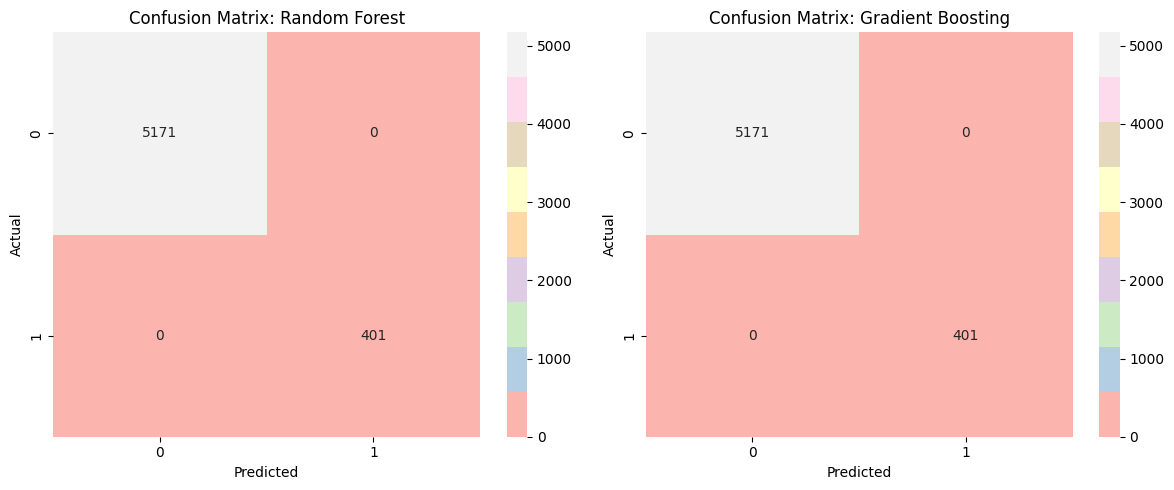

In [5]:

# Confusion matrices
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Pastel1')
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Pastel1')
plt.title('Confusion Matrix: Gradient Boosting')
plt.xlabel('Predicted'); plt.ylabel('Actual')

plt.tight_layout()
plt.show()


## ROC Curve
roc_curve() computes the FPR and TPR at various thresholds.

    fpr_rf, tpr_rf: for the Random Forest model.

    fpr_gb, tpr_gb: for the Gradient Boosting model.

proba_rf and proba_gb are the predicted probabilities from the models (not class labels).

The ROC curves are plotted for each model:

    The closer the curve follows the top-left corner, the better the model performance.

plt.plot([0, 1], [0, 1], 'k--') plots a diagonal line representing a random classifier (baseline).

Axes:

    X-axis: False Positive Rate (1 - Specificity)

    Y-axis: True Positive Rate (Sensitivity / Recall)

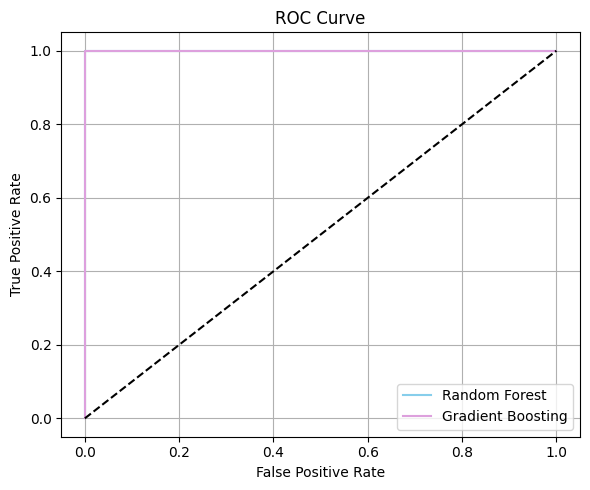

In [6]:

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, proba_gb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='skyblue')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting', color='plum')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Bar Chart
metrics_df: a DataFrame where rows are the models, and columns are the performance metrics.

kind='bar': tells pandas to make a grouped bar chart.

color: uses different colors for easy distinction (Random Forest vs Gradient Boosting).

plt.ylim(0, 1.1): ensures all bars fit within the plot window and allows comparison near the maximum value of 1.

What Is Shown:

    Accuracy: How often the model was correct.

    Precision: Out of all predicted positives, how many were actually positive.

    Recall: Out of all actual positives, how many the model correctly identified.

    F1 Score: The harmonic mean of Precision and Recall


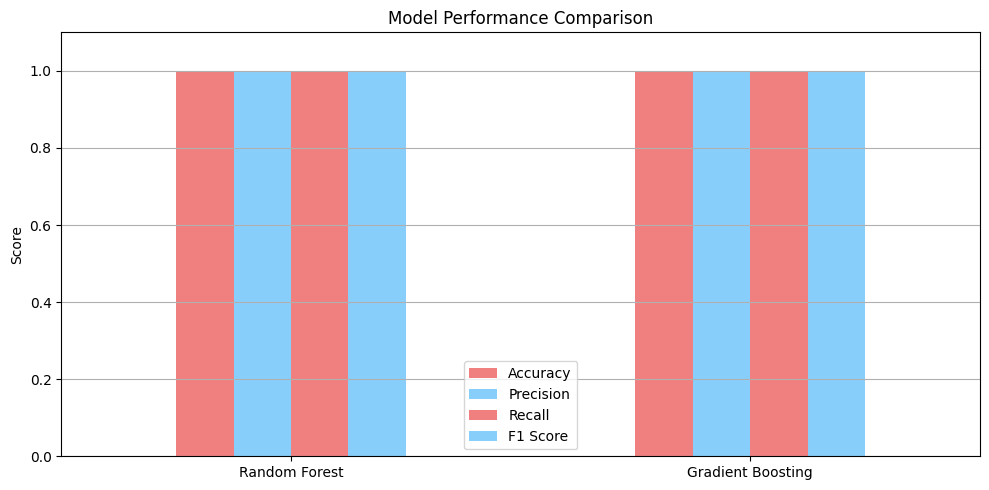

In [7]:

# Bar chart comparing metrics
metrics_df.plot(kind='bar', color=['lightcoral', 'lightskyblue'], figsize=(10, 5))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
